## Modeling for predicting critical outcome at ED triage

Work Flow:
1. Task-specific filter
2. Variable selection
3. Modeling script
4. Performance output


### Load train and test

In [1]:
import os
import time
import random
import tensorflow as tf
import numpy as np
import pandas as pd
import math
import tensorflow.keras as keras
from ast import literal_eval

from matplotlib import pyplot as plt
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras import optimizers, metrics, layers, Model
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import load_model
from helpers import PlotROCCurve
from dataset_path import output_path

try:
    tf.keras.mixed_precision.set_global_policy('mixed_float16')
    print("Mixed precision ON")
except Exception as e:
    print("Mixed precision OFF:", e)
    
path = output_path
output_path = os.path.join(path, "Figure3")

df_train = pd.read_csv((os.path.join(path, 'train.csv')))
df_test = pd.read_csv((os.path.join(path, 'test.csv')))
confidence_interval = 95
random_seed = 0

2025-08-17 16:38:23.297546: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-08-17 16:38:23.311818: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-08-17 16:38:23.315852: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-08-17 16:38:23.328403: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-08-17 16:38:24.292832: W tensorflow/compiler/tf2

Mixed precision ON


In [2]:
random.seed(random_seed)
np.random.seed(random_seed)

In [3]:
pd.set_option('display.max_columns', 100) 
pd.set_option('display.max_rows', 100) 

df_train.head()

,index,subject_id,hadm_id,stay_id,intime,outtime,gender,race,arrival_transport,disposition,anchor_age,anchor_year,dod,admittime,dischtime,deathtime,ethnicity,edregtime,edouttime,insurance,in_year,age,outcome_inhospital_mortality,ed_los,intime_icu,time_to_icu_transfer,outcome_icu_transfer_12h,outcome_hospitalization,outcome_critical,n_ed_30d,n_ed_90d,n_ed_365d,next_ed_visit_time,next_ed_visit_time_diff,outcome_ed_revisit_3d,n_hosp_30d,n_hosp_90d,n_hosp_365d,n_icu_30d,n_icu_90d,n_icu_365d,ed_los_hours,time_to_icu_transfer_hours,next_ed_visit_time_diff_days,triage_temperature,triage_heartrate,triage_resprate,triage_o2sat,triage_sbp,triage_dbp,...,cci_Liver2,cci_Cancer2,cci_HIV,eci_CHF,eci_Arrhythmia,eci_Valvular,eci_PHTN,eci_PVD,eci_HTN1,eci_HTN2,eci_Paralysis,eci_NeuroOther,eci_Pulmonary,eci_DM1,eci_DM2,eci_Hypothyroid,eci_Renal,eci_Liver,eci_PUD,eci_HIV,eci_Lymphoma,eci_Tumor2,eci_Tumor1,eci_Rheumatic,eci_Coagulopathy,eci_Obesity,eci_WeightLoss,eci_FluidsLytes,eci_BloodLoss,eci_Anemia,eci_Alcohol,eci_Drugs,eci_Psychoses,eci_Depression,ed_temperature_last,ed_heartrate_last,ed_resprate_last,ed_o2sat_last,ed_sbp_last,ed_dbp_last,ed_pain_last,n_med,n_medrecon,triage_MAP,score_CCI,score_CART,score_REMS,score_NEWS,score_NEWS2,score_MEWS
0,90728,12155170,NaN,30810678,2157-10-18 07:58:00,2157-10-18 13:35:00,M,WHITE,AMBULANCE,HOME,47.0,2157.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2157,47.0,False,0 days 05:37:00,NaN,NaN,False,False,False,0,0,0,NaN,NaN,False,0,0,0,0,0,0,5.62,NaN,NaN,36.555556,87.0,18.0,97.0,119.0,83.0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,36.555556,94.0,18.0,97.0,139.0,93.0,5.0,2.0,12.0,95.000000,0,0,2,0,0,1
1,84908,12020576,NaN,33335111,2149-11-30 19:15:00,2149-11-30 21:49:00,M,OTHER,WALK IN,HOME,44.0,2149.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2149,44.0,False,0 days 02:34:00,NaN,NaN,False,False,False,0,0,0,2149-12-19 19:58:00,18 days 22:09:00,False,0,0,0,0,0,0,2.57,NaN,18.92,36.555556,64.0,18.0,100.0,151.0,93.0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,36.111111,84.0,13.0,100.0,127.0,70.0,0.0,4.0,0.0,112.333333,0,0,4,0,0,1
2,375094,18818507,NaN,39510756,2205-01-05 11:34:00,2205-01-05 16:54:00,M,BLACK/AFRICAN AMERICAN,WALK IN,ELOPED,44.0,2198.0,NaN,NaN,NaN,NaN,BLACK/AFRICAN AMERICAN,NaN,NaN,NaN,2205,51.0,False,0 days 05:20:00,NaN,NaN,False,False,False,0,0,2,2205-09-24 07:27:00,261 days 14:33:00,False,0,0,1,0,0,0,5.33,NaN,261.61,37.111111,74.0,18.0,98.0,178.0,103.0,...,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,36.666667,75.0,16.0,99.0,146.0,100.0,0.0,4.0,6.0,128.000000,1,0,4,0,0,1
3,211628,14995724,26467950.0,34723899,2123-12-06 11:51:00,2123-12-06 17:56:00,M,WHITE,AMBULANCE,ADMITTED,91.0,2123.0,2128-11-22,2123-12-06 16:00:00,2123-12-09 18:01:00,NaN,WHITE,2123-12-06 11:51:00,2123-12-06 17:56:00,Medicare,2123,91.0,False,0 days 06:05:00,NaN,NaN,False,True,False,0,0,0,2126-03-14 12:24:00,828 days 18:28:00,False,0,0,0,0,0,0,6.08,NaN,828.77,36.277778,66.0,14.0,96.0,129.0,53.0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,36.611111,60.0,18.0,94.0,122.0,66.0,0.0,2.0,10.0,78.333333,4,9,8,0,0,0
4,101301,12406461,23331394.0,36115826,2131-01-18 21:17:00,2131-01-19 03:20:00,F,WHITE,WALK IN,ADMITTED,23.0,2125.0,NaN,2131-01-19 01:40:00,2131-02-13 18:30:00,NaN,WHITE,2131-01-18 21:17:00,2131-01-19 03:20:00,Medicare,2131,29.0,False,0 days 06:03:00,NaN,NaN,False,True,False,1,3,12,2131-03-02 20:56:00,42 days 17:36:00,False,1,3,10,0,0,0,6.05,NaN,42.73,38.166667,133.0,18.0,100.0,136.0,89.0,...,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,1,1,1,1,0,0,0,0,37.111111,86.0,18.0,100.0,127.0,79.0,0.0,2.0,13.0,104.666667,1,4,2,4,4,4


### 1. Task-specific filter: no task-specific exclusion needed

In [4]:
print('training size =', len(df_train), ', testing size =', len(df_test))

training size = 334420 , testing size = 83605


### 2. Variable Selection

In [5]:
variable = ["age", "gender", 
            
            "n_ed_30d", "n_ed_90d", "n_ed_365d", "n_hosp_30d", "n_hosp_90d", 
            "n_hosp_365d", "n_icu_30d", "n_icu_90d", "n_icu_365d", 
            
            "triage_temperature", "triage_heartrate", "triage_resprate", 
            "triage_o2sat", "triage_sbp", "triage_dbp", "triage_pain", "triage_acuity",
            
            "chiefcom_chest_pain", "chiefcom_abdominal_pain", "chiefcom_headache",
            "chiefcom_shortness_of_breath", "chiefcom_back_pain", "chiefcom_cough", 
            "chiefcom_nausea_vomiting", "chiefcom_fever_chills", "chiefcom_syncope", 
            "chiefcom_dizziness", 
            
            "cci_MI", "cci_CHF", "cci_PVD", "cci_Stroke", "cci_Dementia", 
            "cci_Pulmonary", "cci_Rheumatic", "cci_PUD", "cci_Liver1", "cci_DM1", 
            "cci_DM2", "cci_Paralysis", "cci_Renal", "cci_Cancer1", "cci_Liver2", 
            "cci_Cancer2", "cci_HIV", 
            
            "eci_Arrhythmia", "eci_Valvular", "eci_PHTN",  "eci_HTN1", "eci_HTN2", 
            "eci_NeuroOther", "eci_Hypothyroid", "eci_Lymphoma", "eci_Coagulopathy", 
            "eci_Obesity", "eci_WeightLoss", "eci_FluidsLytes", "eci_BloodLoss",
            "eci_Anemia", "eci_Alcohol", "eci_Drugs","eci_Psychoses", "eci_Depression"]

outcome = "outcome_critical"

In [6]:
X_train = df_train[variable].copy()
y_train = df_train[outcome].copy()
X_test = df_test[variable].copy()
y_test = df_test[outcome].copy()

In [7]:
y_train.head()

0    False
1    False
2    False
3    False
4    False
Name: outcome_critical, dtype: bool

In [8]:
X_train.dtypes.to_frame().T

,age,gender,n_ed_30d,n_ed_90d,n_ed_365d,n_hosp_30d,n_hosp_90d,n_hosp_365d,n_icu_30d,n_icu_90d,n_icu_365d,triage_temperature,triage_heartrate,triage_resprate,triage_o2sat,triage_sbp,triage_dbp,triage_pain,triage_acuity,chiefcom_chest_pain,chiefcom_abdominal_pain,chiefcom_headache,chiefcom_shortness_of_breath,chiefcom_back_pain,chiefcom_cough,chiefcom_nausea_vomiting,chiefcom_fever_chills,chiefcom_syncope,chiefcom_dizziness,cci_MI,cci_CHF,cci_PVD,cci_Stroke,cci_Dementia,cci_Pulmonary,cci_Rheumatic,cci_PUD,cci_Liver1,cci_DM1,cci_DM2,cci_Paralysis,cci_Renal,cci_Cancer1,cci_Liver2,cci_Cancer2,cci_HIV,eci_Arrhythmia,eci_Valvular,eci_PHTN,eci_HTN1,eci_HTN2,eci_NeuroOther,eci_Hypothyroid,eci_Lymphoma,eci_Coagulopathy,eci_Obesity,eci_WeightLoss,eci_FluidsLytes,eci_BloodLoss,eci_Anemia,eci_Alcohol,eci_Drugs,eci_Psychoses,eci_Depression
0,float64,object,int64,int64,int64,int64,int64,int64,int64,int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64


In [9]:
encoder = LabelEncoder()
X_train['gender'] = encoder.fit_transform(X_train['gender'])
X_test['gender'] = encoder.transform(X_test['gender'])

In [10]:
print('class ratio')
ratio = y_train.sum()/(~y_train).sum()
print('positive : negative =', ratio, ': 1')

class ratio
positive : negative = 0.0632135488034794 : 1


### 3.  Modeling script

In [11]:
# Containers for all results
result_list = []

Logistic Regression:


/home/olavo-dalberto/gpt_ed_assistant/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training time: 8.461064338684082 seconds
AUC: 0.8688591508088657
AUPRC: 0.3380403955543497
Sensitivity: 0.7943588717743548
Specificity: 0.7834898099381726
Score thresold: 0.06456396820203736
2.5 97.5


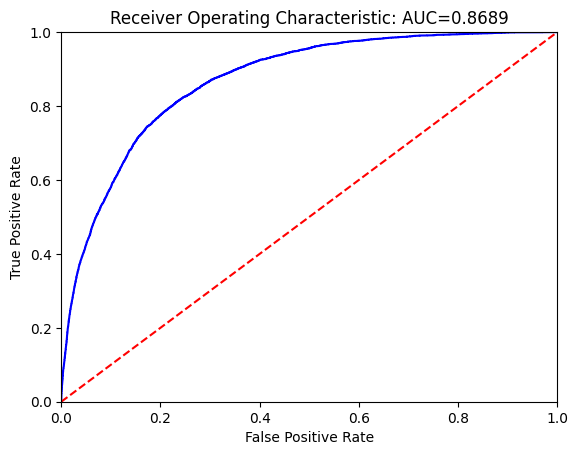

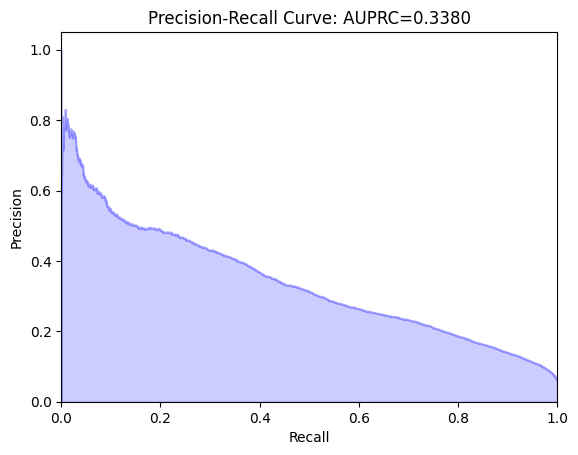

In [12]:
print("Logistic Regression:")
from sklearn.linear_model import LogisticRegression
logreg=LogisticRegression(random_state=random_seed)
start = time.time()
logreg.fit(X_train,y_train)
runtime = time.time()-start
import pickle
with open('task2_logreg.pickle', 'wb') as model_dump:
    pickle.dump(logreg, model_dump)
print('Training time:', runtime, 'seconds')
probs = logreg.predict_proba(X_test)
result = PlotROCCurve(probs[:,1], y_test, ci=confidence_interval, random_seed=random_seed)

results = ["LR"]
results.extend(result)
results.append(runtime)
result_list.append(results)

RandomForest:
Training time: 48.9382061958313 seconds
AUC: 0.8744577630891417
AUPRC: 0.3833579215334083
Sensitivity: 0.7985597119423885
Specificity: 0.7924967559728265
Score thresold: 0.08
2.5 97.5


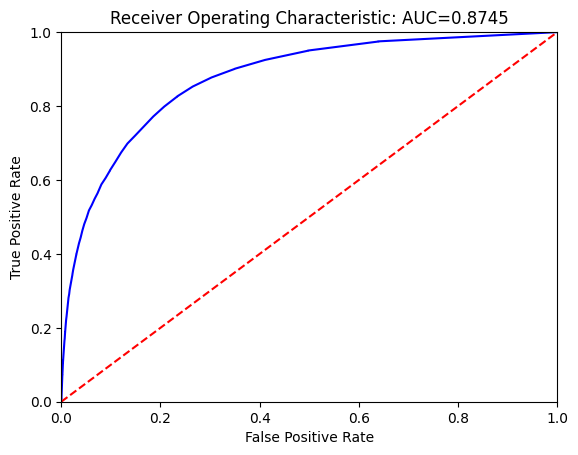

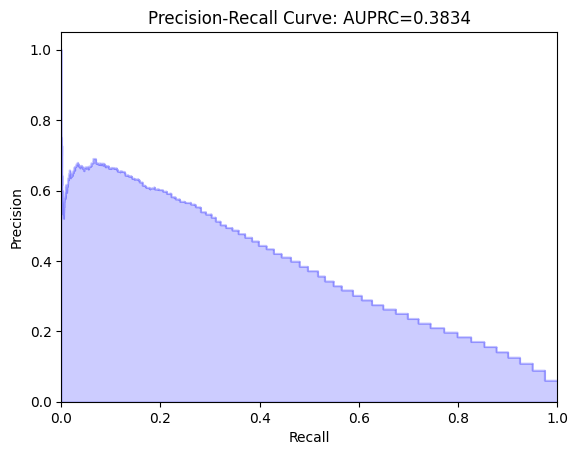

[0.09988771 0.01484144 0.00639996 0.01029735 0.01890328 0.00624516
 0.01004576 0.01701025 0.00334314 0.00666583 0.01223075 0.07557815
 0.09340216 0.05578665 0.04932532 0.10036198 0.08335404 0.04104724
 0.09287841 0.00590166 0.00623576 0.0039156  0.00170974 0.00214944
 0.00241476 0.00304118 0.00484791 0.00353635 0.00308946 0.00520585
 0.00569814 0.00501543 0.00501183 0.00287619 0.00734197 0.00268722
 0.00277066 0.00474289 0.00743372 0.00477266 0.0025056  0.00501743
 0.00544903 0.00297326 0.0037729  0.00115899 0.00720277 0.00481232
 0.00451416 0.00505307 0.0087219  0.00593746 0.00559495 0.00177965
 0.00543044 0.00553953 0.00470989 0.00699239 0.00227147 0.00454754
 0.00487287 0.00362613 0.00261583 0.00689743]


In [13]:
print("RandomForest:")
from sklearn.ensemble import RandomForestClassifier
rf= RandomForestClassifier(random_state=random_seed)
start = time.time()
rf.fit(X_train,y_train)
runtime = time.time()-start
print('Training time:', runtime, 'seconds')
probs = rf.predict_proba(X_test)
result = PlotROCCurve(probs[:,1],y_test, ci=confidence_interval, random_seed=random_seed)
importances = rf.feature_importances_
print(importances)

results = ["RF"]
results.extend(result)
results.append(runtime)
result_list.append(results)

GradientBoosting:
Training time: 55.10559058189392 seconds
AUC: 0.8832271339391151
AUPRC: 0.4008583884482887
Sensitivity: 0.8149629925985197
Specificity: 0.789430832251991
Score thresold: 0.06313583755467111
2.5 97.5


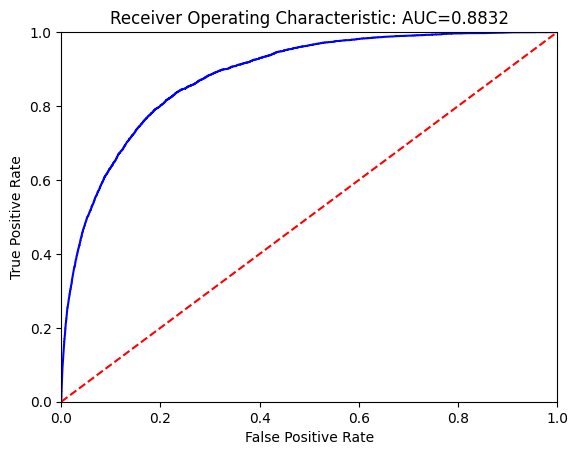

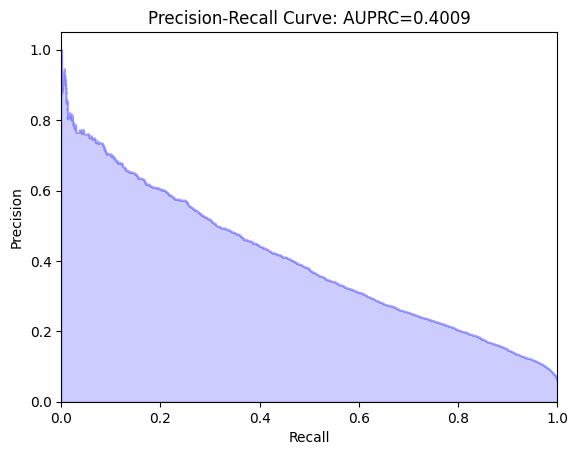

In [14]:
print("GradientBoosting:")
from sklearn.ensemble import GradientBoostingClassifier
gb = GradientBoostingClassifier(random_state=random_seed)
start = time.time()
gb.fit(X_train, y_train)
runtime = time.time()-start
print('Training time:', runtime, 'seconds')
probs = gb.predict_proba(X_test)
result = PlotROCCurve(probs[:,1],y_test, ci=confidence_interval, random_seed=random_seed)

results = ["GB"]
results.extend(result)
results.append(runtime)
result_list.append(results)

In [15]:
from tensorflow.keras.saving import register_keras_serializable

@register_keras_serializable(package="custom", name="MLP")
class MLP(tf.keras.Model):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.dense_1 = Dense(128, activation='relu')
        self.dense_2 = Dense(64, activation='relu')
        self.classifier = Dense(1, activation='sigmoid')

    def call(self, x):
        x = self.dense_1(x)
        x = self.dense_2(x)
        return self.classifier(x)

    def get_config(self):
        config = super().get_config()
        return config

In [16]:
# skip this cell if not retraining
mlp = MLP()
mlp.compile(
    loss='binary_crossentropy',
    optimizer=optimizers.Adam(learning_rate=0.001),
    metrics=[
        'accuracy',
        metrics.AUC(name='AUC'),
        metrics.AUC(name='auprc', curve='PR'),
        metrics.TruePositives(),
        metrics.TrueNegatives(),
        metrics.Precision(),
        metrics.Recall()
    ]
)
start = time.time()
mlp.fit(X_train.astype(np.float32), y_train, batch_size=200, epochs=20)
runtime = time.time() - start
print('Training time:', runtime, 'seconds')
mlp.save('critical_triage_mlp.keras')

Epoch 1/20


I0000 00:00:1755459626.331152  166793 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-08-17 16:40:26.725053: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2343] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


1673/1673 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - AUC: 0.4997 - accuracy: 0.9372 - auprc: 0.0592 - loss: 0.9744 - precision: 0.0508 - recall: 0.0032 - true_negatives: 313359.0000 - true_positives: 63.0000
Epoch 2/20
1673/1673 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.5000 - accuracy: 0.9405 - auprc: 0.0595 - loss: 0.9583 - precision: 0.0000e+00 - recall: 0.0000e+00 - true_negatives: 314537.0000 - true_positives: 0.0000e+00
Epoch 3/20
1673/1673 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.5000 - accuracy: 0.9405 - auprc: 0.0595 - loss: 0.9583 - precision: 0.0000e+00 - recall: 0.0000e+00 - true_negatives: 314537.0000 - true_positives: 0.0000e+00
Epoch 4/20
1673/1673 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.5000 - accuracy: 0.9405 - auprc: 0.0595 - loss: 0.9583 - precision: 0.0000e+00 - recall: 0.0000e+00 - true_negatives: 314537.0000 - true_positives: 0.0000e+00
Epoch 5/20
1673/1673 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.5000 - accuracy: 0.9405 - auprc: 0.0595 - loss: 0.9583 - precision: 0.0

MLP:
2613/2613 ━━━━━━━━━━━━━━━━━━━━ 1s 503us/step
AUC: 0.4999936391624049
AUPRC: 0.05979307457687937
Sensitivity: 0.0
Specificity: 1.0
Score thresold: inf
2.5 97.5


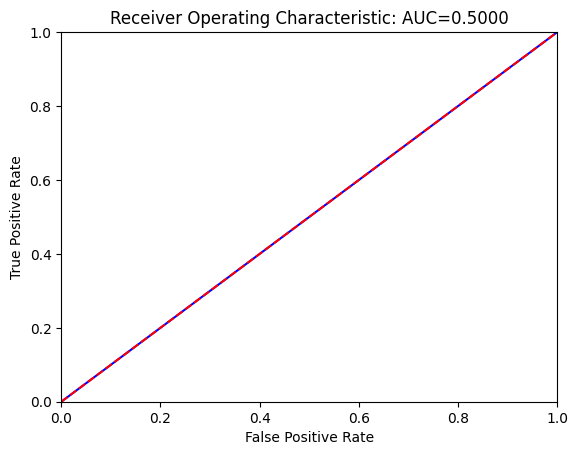

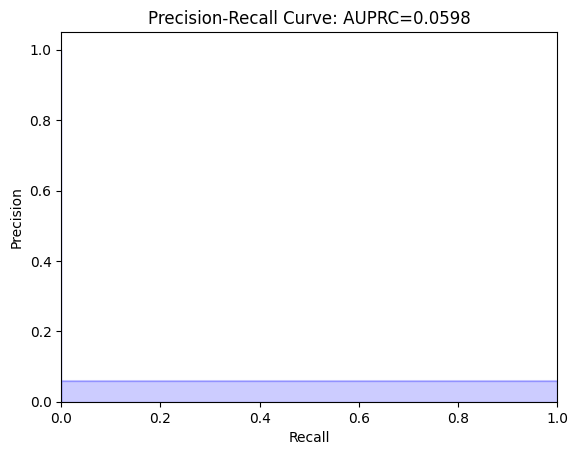

In [17]:
print("MLP:")
mlp = load_model('critical_triage_mlp.keras')
probs = mlp.predict(X_test.astype(np.float32))
result = PlotROCCurve(probs,y_test, ci=confidence_interval, random_seed=random_seed)
results = ["MLP"]
results.extend(result)
results.append(runtime)
result_list.append(results)

In [18]:
def get_score_performance(s, random_seed=0):
    print(s)
    score = np.array(df_test[s])
    result = PlotROCCurve(score,y_test, ci=confidence_interval, random_seed=random_seed)
    runtime = 0
    results = [s]
    results.extend(result)
    results.append(runtime)
    result_list.append(results)


ESI
AUC: 0.8062646585241532
AUPRC: 0.19954909486573122
Sensitivity: 0.8765753150630126
Specificity: 0.6397857669897973
Score thresold: -2.0
2.5 97.5


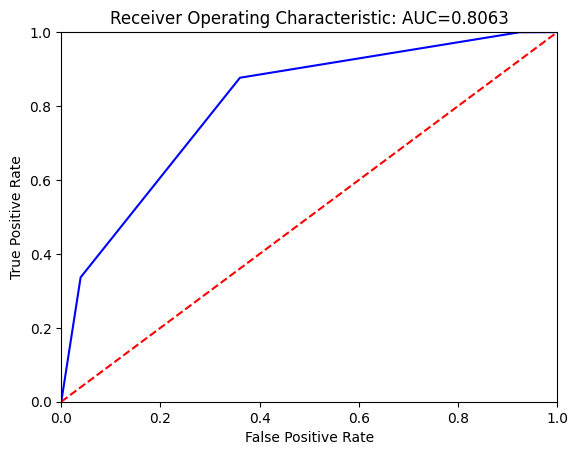

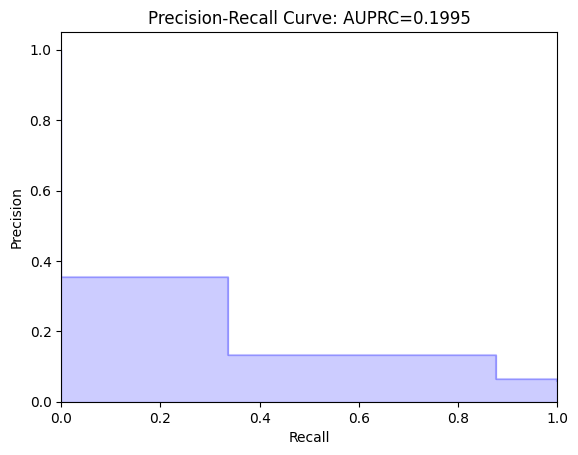

In [19]:
df_test["ESI"] = -df_test["triage_acuity"]
get_score_performance("ESI", random_seed=random_seed)

score_NEWS
AUC: 0.6408746344846915
AUPRC: 0.1575073689891738
Sensitivity: 0.46949389877975595
Specificity: 0.7957153397959443
Score thresold: 2.0
2.5 97.5


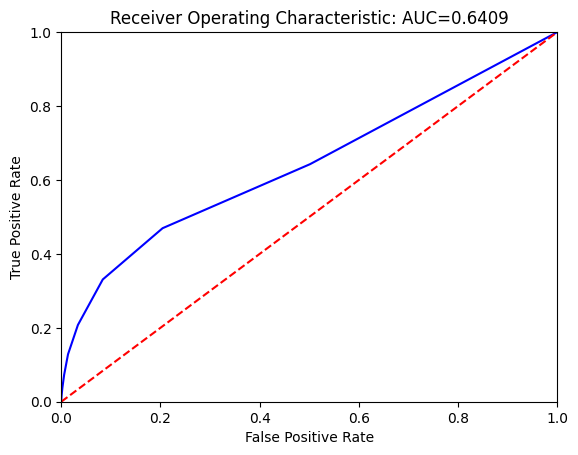

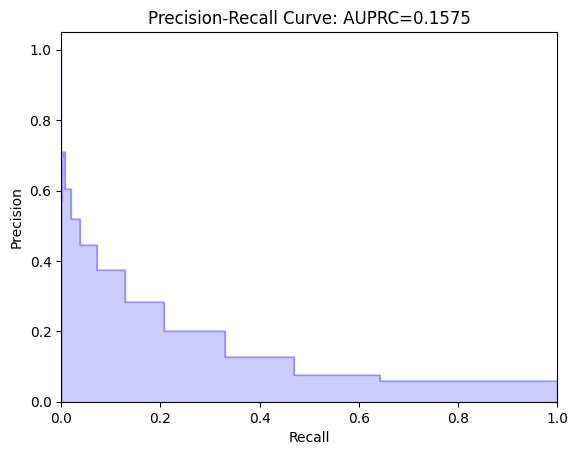

In [20]:
get_score_performance("score_NEWS", random_seed=random_seed)

score_NEWS2
AUC: 0.6272065279910929
AUPRC: 0.14309106464981608
Sensitivity: 0.42768553710742147
Specificity: 0.8233468183090349
Score thresold: 2.0
2.5 97.5


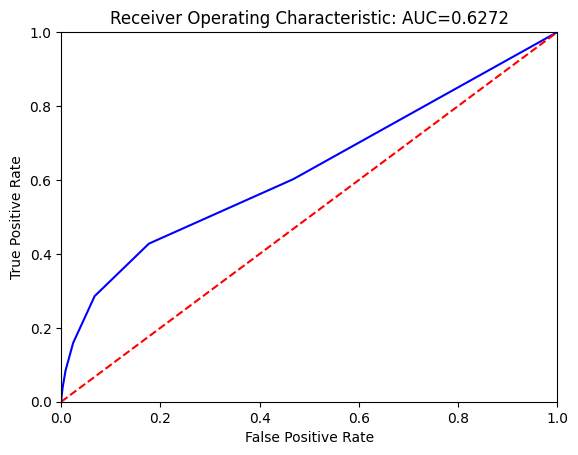

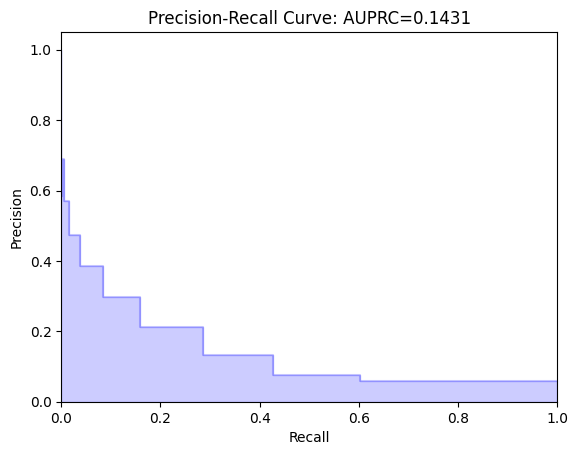

In [21]:
get_score_performance("score_NEWS2", random_seed=random_seed)

score_REMS
AUC: 0.6923937862401374
AUPRC: 0.11613937314535928
Sensitivity: 0.6879375875175034
Specificity: 0.6137699412258606
Score thresold: 5.0
2.5 97.5


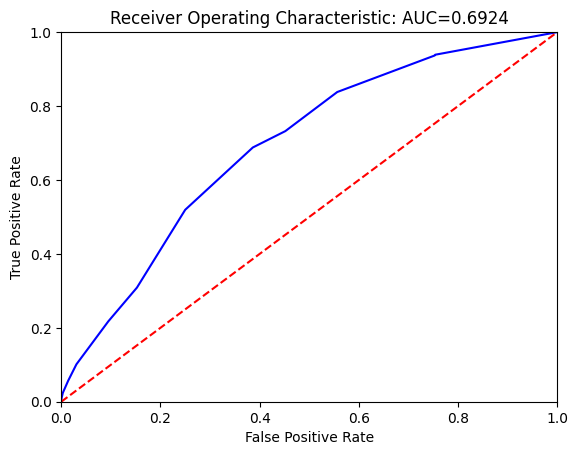

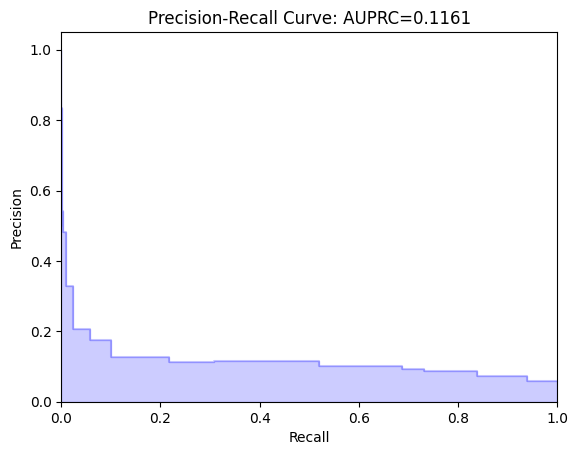

In [22]:
get_score_performance("score_REMS", random_seed=random_seed)

score_MEWS
AUC: 0.6263511333923402
AUPRC: 0.11539084186381711
Sensitivity: 0.4520904180836167
Specificity: 0.7720784672925731
Score thresold: 2.0
2.5 97.5


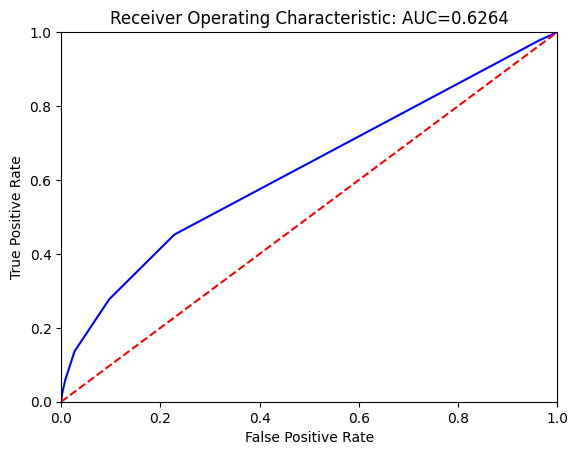

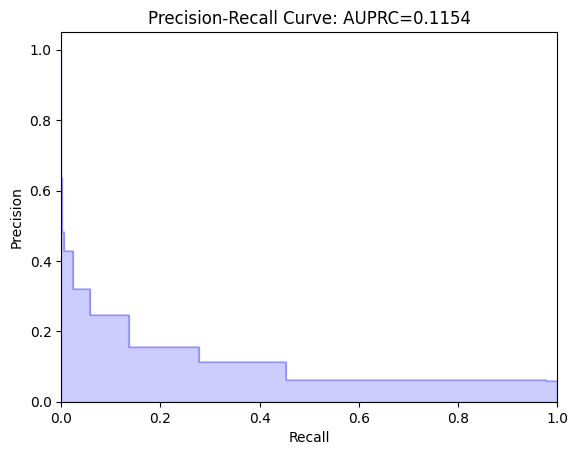

In [23]:
get_score_performance("score_MEWS", random_seed=random_seed)

score_CART
AUC: 0.7148543733121353
AUPRC: 0.15675383285882336
Sensitivity: 0.6033206641328266
Specificity: 0.727794315955525
Score thresold: 6.0
2.5 97.5


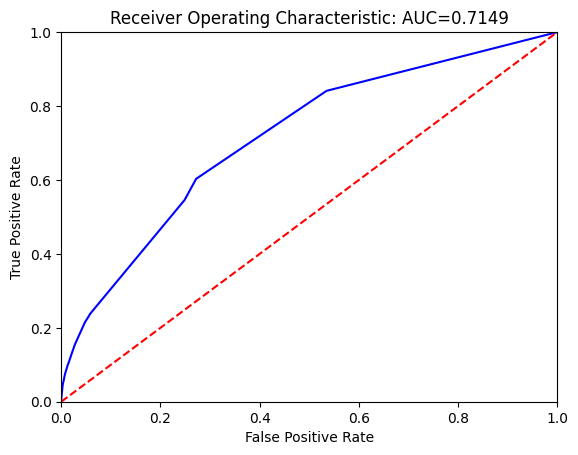

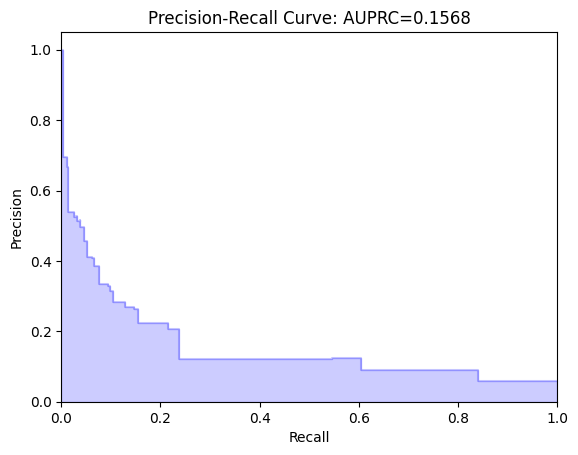

In [24]:
get_score_performance("score_CART", random_seed=random_seed)

In [25]:
from embedding import *

In [26]:
print("Med2Vec:")
version = 'v10'
batch_size=200
vocab_size = vocabulary_map[version]
df_icd_encode = pd.read_csv(os.path.join(path, 'icd_list_dataset_'+version+'.csv'))
df_train_embed = pd.merge(df_train, df_icd_encode[['stay_id', 'icd_encoded_list']], how='left', on='stay_id')
df_test_embed = pd.merge(df_test, df_icd_encode[['stay_id', 'icd_encoded_list']], how='left', on='stay_id')

train_gen, test_gen = setup_embedding_data(df_train_embed, df_test_embed, X_train, y_train, X_test, y_test, batch_size)

Med2Vec:


In [27]:
tf.keras.mixed_precision.set_global_policy('float32')
print("Policy:", tf.keras.mixed_precision.global_policy())

Policy: <DTypePolicy "float32">


In [28]:
# To train from scratch, set load_model to None
load_model = None#"embedding_critical_"+version 
save_model = "embedding_critical_"+version

if load_model:
        model = keras.models.load_model(load_model)
else:
        model = create_embedding_model(vocab_size, len(variable))
model.summary()
model.compile(loss='binary_crossentropy', 
        optimizer=optimizers.Adam(learning_rate=0.001, decay=0.01), 
        metrics=['accuracy', metrics.AUC(name='AUC'), metrics.AUC(name='aucpr', curve='PR'), 
                    metrics.TruePositives(), metrics.TrueNegatives(), metrics.Precision(), metrics.Recall()])
runtime = 1063.299 # to be updated
if not load_model:
        start = time.time()
        model.fit(train_gen, epochs=100, class_weight={1:ratio, 0:1}, verbose=1)
        runtime = time.time()-start
        print('Training time:', runtime, 'seconds')
if save_model:
        keras.models.save_model(model, save_model)
output = model.predict(test_gen)
result = PlotROCCurve(output,y_test, ci=confidence_interval, random_seed=random_seed)

results = ["Med2Vec"]
results.extend(result)
results.append(runtime)
result_list.append(results)


ValueError: Cannot convert '64' to a shape.

In [ ]:
demo_size = X_train_np.shape[1]  # deve ser len(variable) ou 64 no seu caso

model = create_embedding_model(vocab_size=vocab_size, demo_size=X_train_np.shape[1], emb_dim=128, hid=128)

loss_obj = tf.keras.losses.BinaryCrossentropy(
    from_logits=False, label_smoothing=1e-3  # suaviza e evita saturação dura
)
opt = optimizers.Adam(learning_rate=5e-5, clipnorm=1.0)  # LR menor + clip


model.compile(
    loss=loss_obj,
    optimizer=opt,
    metrics=[
        'accuracy',
        metrics.AUC(name='AUC'),
        metrics.AUC(name='AUPRC', curve='PR'),
        metrics.Precision(name='Precision'),
        metrics.Recall(name='Recall'),
        metrics.TruePositives(name='TP'),
        metrics.TrueNegatives(name='TN'),
    ],
)
model.summary()

# Desbalanceamento (positivos são raros)
pos = float(y_train_np.sum())
neg = float(len(y_train_np) - pos)
ratio = (neg / max(pos, 1.0)) if pos > 0 else 1.0
ratio = float(min(ratio, 50.0))  # CAP em 50
class_weight = {0: 1.0, 1: ratio}
print("class_weight", class_weight)

start = time.time()
hist = model.fit(train_gen, epochs=50, class_weight=class_weight, verbose=1)
runtime = time.time() - start
print('Training time:', runtime, 'seconds')


Model: "med2vec_cls"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ icd_input           │ (None, None)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ demograph_input     │ (None, 64)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ icd_emb (Embedding) │ (None, None, 128) │  3,656,192 │ icd_input[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal           │ (None, None)      │          0 │ icd_input[0][0]   │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_6 (Dense)     │ (None, 128)       │      8,320 │ demograph_input[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 128)       │          0 │ icd_emb[0][0],    │
│ (GlobalAveragePool… │                   │            │ not_equal[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 256)       │          0 │ dense_6[0][0],    │
│ (Concatenate)       │                   │            │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_7 (Dense)     │ (None, 128)       │     32,896 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_8 (Dense)     │ (None, 64)        │      8,256 │ dense_7[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_9 (Dense)     │ (None, 1)         │         65 │ dense_8[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 3,705,729 (14.14 MB)

 Trainable params: 3,705,729 (14.14 MB)

 Non-trainable params: 0 (0.00 B)

class_weight {0: 1.0, 1: 15.8193934516924}
Epoch 1/50


/home/olavo-dalberto/gpt_ed_assistant/.venv/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1673/1673 ━━━━━━━━━━━━━━━━━━━━ 110s 65ms/step - AUC: 2.6144e-08 - AUPRC: 1.6741e-05 - Precision: 0.0000e+00 - Recall: 0.0000e+00 - TN: 314527.0000 - TP: 0.0000e+00 - accuracy: 0.9405 - loss: nan
Epoch 2/50
1673/1673 ━━━━━━━━━━━━━━━━━━━━ 108s 65ms/step - AUC: 0.0000e+00 - AUPRC: 0.0000e+00 - Precision: 0.0000e+00 - Recall: 0.0000e+00 - TN: 314537.0000 - TP: 0.0000e+00 - accuracy: 0.9405 - loss: nan
Epoch 3/50
1673/1673 ━━━━━━━━━━━━━━━━━━━━ 109s 65ms/step - AUC: 0.0000e+00 - AUPRC: 0.0000e+00 - Precision: 0.0000e+00 - Recall: 0.0000e+00 - TN: 314537.0000 - TP: 0.0000e+00 - accuracy: 0.9405 - loss: nan
Epoch 4/50
1673/1673 ━━━━━━━━━━━━━━━━━━━━ 109s 65ms/step - AUC: 0.0000e+00 - AUPRC: 0.0000e+00 - Precision: 0.0000e+00 - Recall: 0.0000e+00 - TN: 314537.0000 - TP: 0.0000e+00 - accuracy: 0.9405 - loss: nan
Epoch 5/50
1673/1673 ━━━━━━━━━━━━━━━━━━━━ 110s 65ms/step - AUC: 0.0000e+00 - AUPRC: 0.0000e+00 - Precision: 0.0000e+00 - Recall: 0.0000e+00 - TN: 314537.0000 - TP: 0.0000e+00 - accuracy: 

KeyboardInterrupt: 

In [ ]:
probs = model.predict(test_gen, verbose=0).ravel().astype('float32')

# Se você já tem o helper:
# result = PlotROCCurve(probs, y_test_np, ci=confidence_interval, random_seed=random_seed)
# results = ["Med2Vec"]; results.extend(result); results.append(runtime)
# result_list.append(results)

# Ou, sem helper, calcule rapidamente AUROC/AUPRC:
from sklearn.metrics import roc_auc_score, average_precision_score
print("AUROC:", roc_auc_score(y_test_np, probs))
print("AUPRC:", average_precision_score(y_test_np, probs))


NameError: name 'max_idx' is not defined

### 4. Performance output

In [26]:
result_df = pd.DataFrame(result_list, columns=['Model', 'auroc', 'ap', 'sensitivity', 'specificity', 'threshold', 
                                               'lower_auroc', 'upper_auroc', 'std_auroc', 'lower_ap', 'upper_ap', 
                                               'std_ap', 'lower_sensitivity', 'upper_sensitivity', 'std_sensitivity', 
                                               'lower_specificity', 'upper_specificity', 'std_specificity', 'runtime'])
result_df.to_csv(os.path.join(path, 'result_critical_triage.csv'), index=False)

result_df = result_df.round(3)
formatted_result_df = pd.DataFrame()
formatted_result_df[['Model', 'Threshold']] = result_df[['Model', 'threshold']]
formatted_result_df['AUROC'] = result_df['auroc'].astype(str) + ' (' + result_df['lower_auroc'].astype(str) + \
                               '-' + result_df['upper_auroc'].astype(str) + ')'
formatted_result_df['AUPRC'] = result_df['ap'].astype(str) + ' (' + result_df['lower_ap'].astype(str) + \
                               '-' + result_df['upper_ap'].astype(str) + ')'
formatted_result_df['Sensitivity'] = result_df['sensitivity'].astype(str) + ' (' + result_df['lower_sensitivity'].astype(str) + \
                                     '-' + result_df['upper_sensitivity'].astype(str) + ')'
formatted_result_df['Specificity'] = result_df['specificity'].astype(str) + ' (' + result_df['lower_specificity'].astype(str) + \
                                     '-' + result_df['upper_specificity'].astype(str) + ')'
formatted_result_df[['Runtime']] = result_df[['runtime']]
formatted_result_df.to_csv(os.path.join(path, 'task2.csv'), index=False)
formatted_result_df

,Model,Threshold,AUROC,AUPRC,Sensitivity,Specificity,Runtime
0,LR,0.065,0.869 (0.866-0.874),0.338 (0.326-0.345),0.794 (0.781-0.813),0.783 (0.762-0.801),10.006
1,RF,0.080,0.874 (0.872-0.88),0.383 (0.372-0.394),0.799 (0.792-0.825),0.792 (0.767-0.794),50.894
2,GB,0.063,0.883 (0.881-0.888),0.401 (0.392-0.413),0.815 (0.792-0.826),0.789 (0.784-0.812),58.349
3,MLP,0.096,0.884 (0.881-0.889),0.391 (0.381-0.402),0.81 (0.802-0.827),0.798 (0.792-0.803),51.679
4,ESI,-2.000,0.806 (0.802-0.811),0.2 (0.194-0.206),0.877 (0.873-0.888),0.64 (0.638-0.644),0.000
5,score_NEWS,2.000,0.641 (0.633-0.65),0.158 (0.151-0.165),0.469 (0.456-0.483),0.796 (0.793-0.798),0.000
6,score_NEWS2,2.000,0.627 (0.619-0.635),0.143 (0.138-0.151),0.428 (0.415-0.44),0.823 (0.821-0.826),0.000
7,score_REMS,5.000,0.692 (0.687-0.701),0.116 (0.113-0.121),0.688 (0.678-0.701),0.614 (0.611-0.617),0.000
8,score_MEWS,2.000,0.626 (0.62-0.631),0.115 (0.112-0.121),0.452 (0.441-0.46),0.772 (0.769-0.775),0.000
9,score_CART,6.000,0.715 (0.711-0.724),0.157 (0.15-0.165),0.603 (0.594-0.618),0.728 (0.725-0.73),0.000


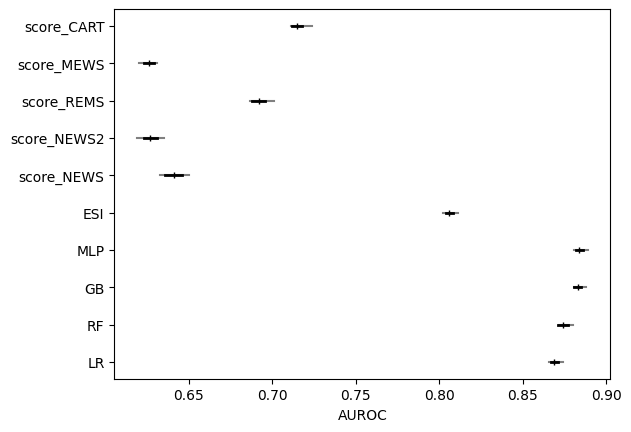

In [27]:
from helpers import plot_confidence_interval
plot_confidence_interval(result_df, metric='auroc', ci=confidence_interval, name = "AUROC", 
                         my_file = 'AUROC_critical.eps', my_path = output_path) 

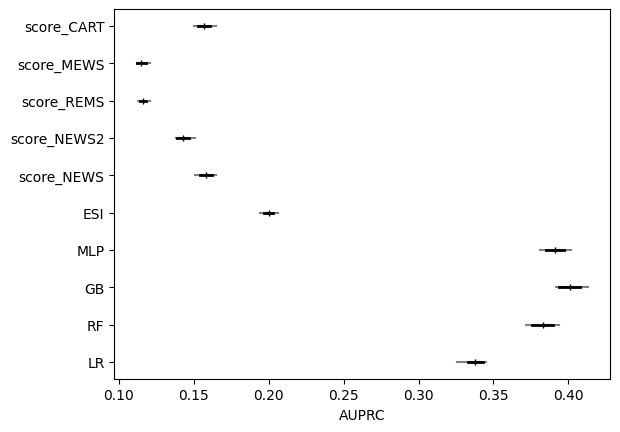

In [28]:
plot_confidence_interval(result_df, metric='ap', ci=confidence_interval, name = "AUPRC", 
                         my_file = 'AUPRC_critical.eps', my_path = output_path)

In [29]:
importance_df = pd.DataFrame(zip(variable, importances), columns=['Variable','Importance'])
importance_df.to_csv(os.path.join(path, 'importances_critical_triage.csv'))
importance_df.sort_values(by='Importance', axis=0,ascending=False)

,Variable,Importance
15,triage_sbp,0.100362
0,age,0.099888
12,triage_heartrate,0.093402
18,triage_acuity,0.092878
16,triage_dbp,0.083354
11,triage_temperature,0.075578
13,triage_resprate,0.055787
14,triage_o2sat,0.049325
17,triage_pain,0.041047
4,n_ed_365d,0.018903
